In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller



## Import the data

In [3]:
from pathlib import Path

path = Path('2018-citibike-tripdata')

csv_files = sorted(path.rglob('*.csv'))

if not csv_files:
    raise FileNotFoundError(f'No CSV files found in {path.resolve()}')

dataframes = []

for csv_file in csv_files:
    try:
        df_temp = pd.read_csv(csv_file)
        df_temp['source_file'] = csv_file.relative_to(path).as_posix()
        dataframes.append(df_temp)
    except Exception as e:
        print(f'Error reading {csv_file}: {e}')

# Concatenate all successfully loaded dataframes
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    print(f'Successfully loaded {len(dataframes)} files totaling {df.shape[0]} rows')
else:
    print('No files were loaded')
    df = pd.DataFrame()





Successfully loaded 35 files totaling 36404221 rows


In [4]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,source_file
0,330,2018-10-01 00:00:00.7010,2018-10-01 00:05:30.8490,293.0,Lafayette St & E 8 St,40.730207,-73.991026,504.0,1 Ave & E 16 St,40.732219,-73.981656,30493,Subscriber,1995,1,10_October/201810-citibike-tripdata_1.csv
1,309,2018-10-01 00:00:13.5780,2018-10-01 00:05:23.2310,433.0,old - E 13 St & Avenue A,40.729554,-73.980572,394.0,E 9 St & Avenue C,40.725213,-73.977688,33054,Subscriber,1967,1,10_October/201810-citibike-tripdata_1.csv
2,734,2018-10-01 00:00:16.6040,2018-10-01 00:12:31.5050,3472.0,W 15 St & 10 Ave,40.742754,-74.007474,285.0,Broadway & E 14 St,40.734546,-73.990741,33400,Subscriber,1983,2,10_October/201810-citibike-tripdata_1.csv
3,788,2018-10-01 00:00:35.0670,2018-10-01 00:13:43.5780,417.0,Barclay St & Church St,40.712912,-74.010202,3472.0,W 15 St & 10 Ave,40.742754,-74.007474,31140,Customer,1988,1,10_October/201810-citibike-tripdata_1.csv
4,1136,2018-10-01 00:00:38.1410,2018-10-01 00:19:34.6490,3699.0,W 50 St & 9 Ave,40.763605,-73.989180,495.0,W 47 St & 10 Ave,40.762699,-73.993012,20294,Subscriber,1969,0,10_October/201810-citibike-tripdata_1.csv


## 1. Clustering of stations

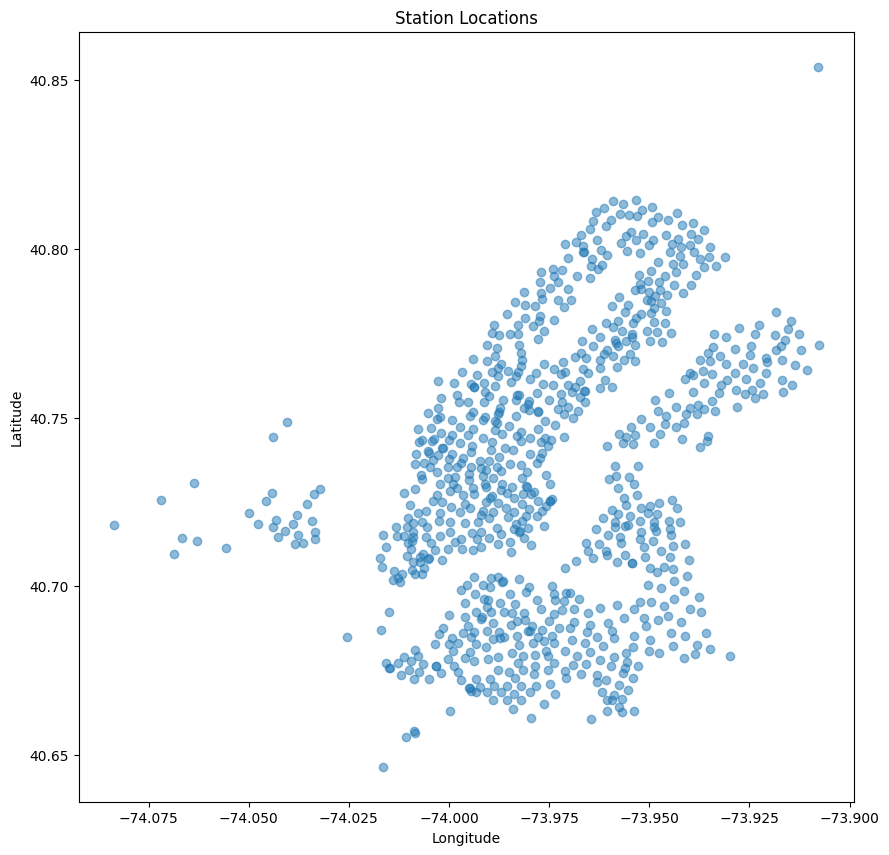

In [5]:
# We want to map each station based on latitude and longitude so that we can assign clusters.
# Combine start and end station metadata to make sure every station appears exactly once.
start_station_info = df[
    ['start station id', 'start station latitude', 'start station longitude', 'start station name']
].drop_duplicates()
start_station_info.columns = ['station_id', 'latitude', 'longitude', 'name']

end_station_info = df[
    ['end station id', 'end station latitude', 'end station longitude', 'end station name']
].drop_duplicates()
end_station_info.columns = ['station_id', 'latitude', 'longitude', 'name']

station_info = (
    pd.concat([start_station_info, end_station_info], ignore_index=True)
    .drop_duplicates(subset='station_id')
    .dropna(subset=['latitude', 'longitude'])
)

# Clean out outliers
station_info = station_info[station_info['latitude'] < 41]
station_info = station_info[station_info['longitude'] < -73.5]

# Plot based on latitude and longitude
plt.figure(figsize=(10, 10))
plt.scatter(station_info['longitude'], station_info['latitude'], alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station Locations')
plt.show()

In [6]:
# Cluster the stations using k-means, minimum 20 clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42)
station_info = station_info.reset_index(drop=True)
kmeans.fit(station_info[['longitude', 'latitude']])
station_info['cluster'] = kmeans.labels_


In [7]:
centers = kmeans.cluster_centers_

# Initialize an empty DataFrame with the correct columns
tmp_frame = pd.DataFrame(columns=['center_station', '# Stations'])

## Print the cluster centers' representative station names
for i, center in enumerate(centers):
    cluster_stations = station_info[station_info['cluster'] == i]
    if cluster_stations.empty:
        continue
    # Convert to numpy array for distance calculation
    station_coords = cluster_stations[['longitude', 'latitude']].values
    center_coords = center.reshape(1, -1)
    distances = np.linalg.norm(station_coords - center_coords, axis=1)
    closest_station = cluster_stations.iloc[np.argmin(distances)]
    tmp_frame.loc[i, 'center_station'] = closest_station['name']
    tmp_frame.loc[i, '# Stations'] = len(cluster_stations)

# Display the table nicely
tmp_frame

,center_station,# Stations
0,Lexington Ave & E 120 St,36
1,E 2 St & Avenue A,61
2,Duffield St & Willoughby St,69
3,E 58 St & 3 Ave,41
4,Hancock St & Bedford Ave,66
5,Columbia St & W 9 St,40
6,49 Ave & 21 St,27
7,W 110 St & Amsterdam Ave,35
8,W 13 St & 7 Ave,59
9,Communipaw & Berry Lane,7


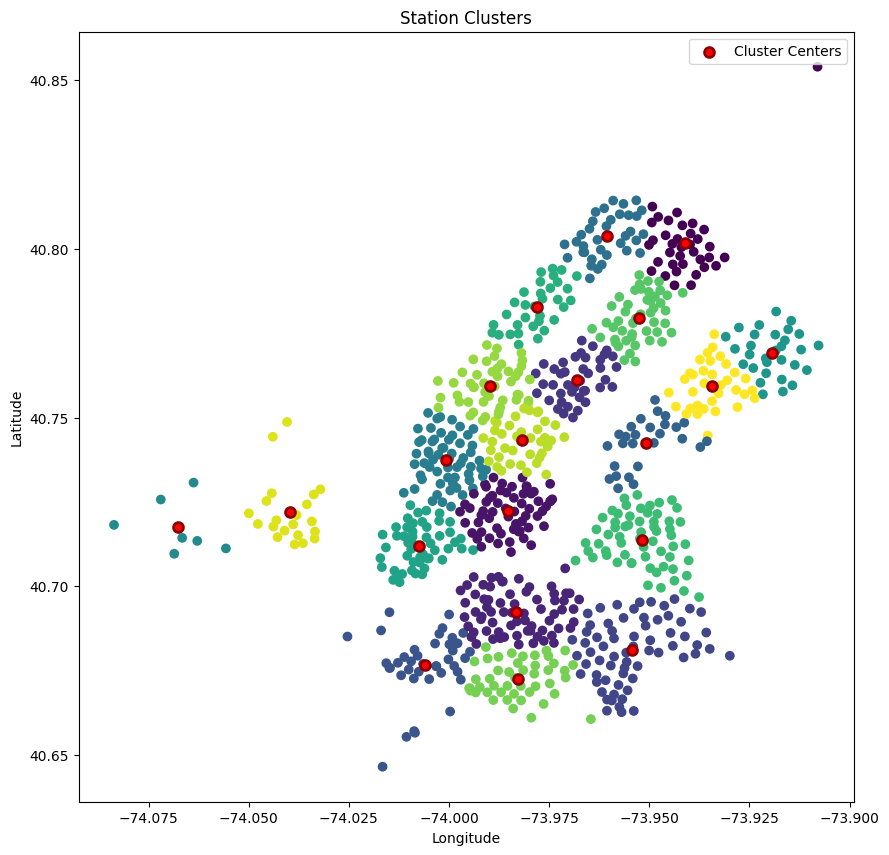

In [8]:
# Plot the clusters
plt.figure(figsize=(10, 10))
plt.scatter(station_info['longitude'], station_info['latitude'], c=station_info['cluster'], cmap='viridis')
# Highlight cluster centers with bright red dots
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c='red',
    marker='o',
    s=50,
    edgecolors='darkred',
    linewidths=2,
    label='Cluster Centers',
    zorder=5,
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station Clusters')
plt.legend()
plt.show()

In [9]:
# Attach cluster labels to each trip for departures (start) and arrivals (end)
station_cluster_map = station_info.set_index('station_id')['cluster'].to_dict()

df['start_cluster'] = df['start station id'].map(station_cluster_map)
df['end_cluster'] = df['end station id'].map(station_cluster_map)

missing_start = df['start_cluster'].isna().sum()
missing_end = df['end_cluster'].isna().sum()
print(
    f"Trips without start cluster: {missing_start:,}, without end cluster: {missing_end:,}"
)



Trips without start cluster: 163, without end cluster: 165


In [10]:
# Prepare hourly departures and arrivals counts per cluster
# Convert timestamps once so downstream steps can reuse them
if not np.issubdtype(df['starttime'].dtype, np.datetime64):
    df['starttime'] = pd.to_datetime(df['starttime'])
if not np.issubdtype(df['stoptime'].dtype, np.datetime64):
    df['stoptime'] = pd.to_datetime(df['stoptime'])

df['start_hour'] = df['starttime'].dt.floor('H')
df['stop_hour'] = df['stoptime'].dt.floor('H')

departures_hourly = (
    df.dropna(subset=['start_cluster'])
    .groupby(['start_cluster', 'start_hour'])
    .size()
    .reset_index(name='departures')
)

arrivals_hourly = (
    df.dropna(subset=['end_cluster'])
    .groupby(['end_cluster', 'stop_hour'])
    .size()
    .reset_index(name='arrivals')
)

cluster_hourly = (
    pd.merge(
        departures_hourly.rename(
            columns={'start_cluster': 'cluster', 'start_hour': 'timestamp'}
        ),
        arrivals_hourly.rename(
            columns={'end_cluster': 'cluster', 'stop_hour': 'timestamp'}
        ),
        on=['cluster', 'timestamp'],
        how='outer',
    )
    .fillna(0)
    .sort_values(['cluster', 'timestamp'])
)

cluster_hourly['date'] = cluster_hourly['timestamp'].dt.date
cluster_hourly['hour'] = cluster_hourly['timestamp'].dt.hour
cluster_hourly.head()


/var/folders/qp/5zn1806d2q183t3j1x_pt5x80000gn/T/ipykernel_2647/3696890600.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['start_hour'] = df['starttime'].dt.floor('H')
/var/folders/qp/5zn1806d2q183t3j1x_pt5x80000gn/T/ipykernel_2647/3696890600.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['stop_hour'] = df['stoptime'].dt.floor('H')


,cluster,timestamp,departures,arrivals,date,hour
0,0.0,2018-01-01 00:00:00,0.0,4.0,2018-01-01,0
1,0.0,2018-01-01 01:00:00,8.0,4.0,2018-01-01,1
2,0.0,2018-01-01 03:00:00,4.0,4.0,2018-01-01,3
3,0.0,2018-01-01 04:00:00,0.0,2.0,2018-01-01,4
4,0.0,2018-01-01 05:00:00,2.0,2.0,2018-01-01,5


## 2. Prediction Challenge

### Cluster-Level Modeling

#### Build a reusable modeling pipeline that we can apply to multiple clusters.

In [11]:
from typing import Tuple


def prepare_cluster_daily_matrices(
    cluster_hourly: pd.DataFrame,
    cluster_id: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    cluster_df = (
        cluster_hourly[cluster_hourly['cluster'] == cluster_id]
        .copy()
        .sort_values('timestamp')
    )
    if cluster_df.empty:
        raise ValueError(f'No records found for cluster {cluster_id}')

    cluster_df['timestamp'] = pd.to_datetime(cluster_df['timestamp'])
    cluster_df['date'] = cluster_df['timestamp'].dt.normalize()

    departures_daily = (
        cluster_df.pivot(index='date', columns='hour', values='departures').fillna(0)
    )
    arrivals_daily = (
        cluster_df.pivot(index='date', columns='hour', values='arrivals').fillna(0)
    )

    return departures_daily, arrivals_daily


def build_daily_feature_matrix(
    departures_daily: pd.DataFrame,
    arrivals_daily: pd.DataFrame,
) -> pd.DataFrame:
    calendar_features = pd.DataFrame(index=departures_daily.index)
    calendar_features['day_of_week'] = calendar_features.index.dayofweek
    calendar_features['is_weekend'] = (calendar_features['day_of_week'] >= 5).astype(int)
    calendar_features['month'] = calendar_features.index.month
    calendar_features['week_of_year'] = calendar_features.index.isocalendar().week.astype(int)
    calendar_features['season'] = calendar_features.index.month % 12 // 3 + 1
    calendar_features['year'] = calendar_features.index.year
    calendar_features['dow_sin'] = np.sin(2 * np.pi * calendar_features['day_of_week'] / 7)
    calendar_features['dow_cos'] = np.cos(2 * np.pi * calendar_features['day_of_week'] / 7)
    calendar_features['month_sin'] = np.sin(2 * np.pi * calendar_features['month'] / 12)
    calendar_features['month_cos'] = np.cos(2 * np.pi * calendar_features['month'] / 12)

    prev_day_departures = departures_daily.shift(1).add_prefix('prev_dep_hour_')
    prev_day_arrivals = arrivals_daily.shift(1).add_prefix('prev_arr_hour_')

    daily_dep_total = departures_daily.sum(axis=1)
    daily_arr_total = arrivals_daily.sum(axis=1)

    lagged_totals = pd.DataFrame(
        {
            'dep_total_lag1': daily_dep_total.shift(1),
            'arr_total_lag1': daily_arr_total.shift(1),
            'dep_total_roll7': daily_dep_total.shift(1).rolling(window=7, min_periods=1).mean(),
            'arr_total_roll7': daily_arr_total.shift(1).rolling(window=7, min_periods=1).mean(),
            'dep_total_roll30': daily_dep_total.shift(1).rolling(window=30, min_periods=1).mean(),
            'arr_total_roll30': daily_arr_total.shift(1).rolling(window=30, min_periods=1).mean(),
        },
        index=departures_daily.index,
    )

    daily_features_base = (
        pd.concat(
            [calendar_features, prev_day_departures, prev_day_arrivals, lagged_totals],
            axis=1,
        )
        .sort_index()
    )

    return daily_features_base



In [12]:
from typing import Dict


def summarize_cluster_performance(
    cluster_label: str,
    metrics: Dict[str, Dict[int, Dict[str, float]]],
    departures_daily: pd.DataFrame,
    arrivals_daily: pd.DataFrame,
    *,
    display_plots: bool = True,
) -> Dict[str, pd.DataFrame]:
    summary_tables: Dict[str, pd.DataFrame] = {}
    if not metrics:
        print(f"No metrics recorded for {cluster_label}; skipping plots.")
        return summary_tables

    for target_type, target_metrics in metrics.items():
        if not target_metrics:
            print(f"No metrics recorded for {cluster_label} {target_type}; skipping plots.")
            continue

        hours_list = sorted(target_metrics.keys())
        val_maes = [target_metrics[h]['Val_MAE'] for h in hours_list]
        test_maes = [target_metrics[h]['Test_MAE'] for h in hours_list]
        val_rmses = [target_metrics[h]['Val_RMSE'] for h in hours_list]
        test_rmses = [target_metrics[h]['Test_RMSE'] for h in hours_list]

        summary_df = pd.DataFrame(
            {
                'hour': hours_list,
                'Val_MAE': val_maes,
                'Val_RMSE': val_rmses,
                'Test_MAE': test_maes,
                'Test_RMSE': test_rmses,
            }
        ).set_index('hour')
        summary_tables[target_type] = summary_df

        avg_profile_source = (
            departures_daily if target_type == 'departures' else arrivals_daily
        )
        avg_profile = avg_profile_source.loc[:, hours_list].mean(axis=0)

        if display_plots:
            fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
            axes[0].plot(
                hours_list,
                val_maes,
                marker='o',
                label='Validation MAE',
                linewidth=2,
            )
            axes[0].plot(
                hours_list,
                test_maes,
                marker='s',
                label='Test MAE',
                linewidth=2,
            )
            axes[0].set_ylabel('MAE')
            axes[0].set_title(f'{cluster_label} {target_type.title()} MAE by Hour')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

            axes[1].plot(
                hours_list,
                val_rmses,
                marker='o',
                label='Validation RMSE',
                linewidth=2,
            )
            axes[1].plot(
                hours_list,
                test_rmses,
                marker='s',
                label='Test RMSE',
                linewidth=2,
            )
            axes[1].set_ylabel('RMSE')
            axes[1].set_title(f'{cluster_label} {target_type.title()} RMSE by Hour')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

            axes[2].plot(hours_list, avg_profile, marker='o')
            axes[2].set_xlabel('Hour of day')
            axes[2].set_ylabel('Average trips')
            axes[2].set_title(f'{cluster_label} Average hourly {target_type}')
            axes[2].grid(True, alpha=0.3)
            axes[2].set_xticks(range(24))

            plt.tight_layout()
            plt.show()

        print(f"\n=== {cluster_label} {target_type.title()} Summary Statistics ===")
        print(f"Average Validation MAE: {np.mean(val_maes):.2f}")
        print(f"Average Test MAE: {np.mean(test_maes):.2f}")
        midday_hours = [11, 12, 13, 14, 15]
        peak_hours = [7, 8, 9, 17, 18]
        print(
            f"Mid-day (11-15) Validation/Test MAE: "
            f"{np.mean([target_metrics[h]['Val_MAE'] for h in midday_hours if h in target_metrics]):.2f} / "
            f"{np.mean([target_metrics[h]['Test_MAE'] for h in midday_hours if h in target_metrics]):.2f}"
        )
        print(
            f"Peak (7-9,17-18) Validation/Test MAE: "
            f"{np.mean([target_metrics[h]['Val_MAE'] for h in peak_hours if h in target_metrics]):.2f} / "
            f"{np.mean([target_metrics[h]['Test_MAE'] for h in peak_hours if h in target_metrics]):.2f}"
        )

    return summary_tables


In [26]:
# Data previews will be produced inside the reusable pipeline as needed.

In [16]:
from typing import Any, Dict, Optional

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

import warnings

warnings.filterwarnings('ignore')

PARAM_GRID: Dict[str, list] = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [3, 5, 10],
}

SPLIT_DATES: Dict[str, pd.Timestamp] = {
    'train_end': pd.Timestamp('2018-09-30'),
    'val_start': pd.Timestamp('2018-10-01'),
    'val_end': pd.Timestamp('2018-10-31'),
    'test_start': pd.Timestamp('2018-11-01'),
}


def train_models_for_cluster(
    departures_daily: pd.DataFrame,
    arrivals_daily: pd.DataFrame,
    daily_features_base: pd.DataFrame,
    split_dates: Dict[str, pd.Timestamp],
    param_grid: Dict[str, list],
    cluster_label: str,
    *,
    random_state: int = 42,
) -> Dict[str, Dict]:
    forecast_targets = {
        'departures': departures_daily,
        'arrivals': arrivals_daily,
    }

    models = {target: {} for target in forecast_targets}
    metrics = {target: {} for target in forecast_targets}
    predictions = {target: {'validation': {}, 'test': {}} for target in forecast_targets}
    best_params = {target: {} for target in forecast_targets}

    for target_type, target_matrix in forecast_targets.items():
        print(f"\n=== Training models for {cluster_label} {target_type} ===")
        for hour in range(24):
            hour_series = target_matrix[hour]

            features_hour = daily_features_base.copy()
            features_hour[f'{target_type}_lag_1'] = hour_series.shift(1)
            features_hour[f'{target_type}_lag_7'] = hour_series.shift(7)
            features_hour[f'{target_type}_lag_30'] = hour_series.shift(30)
            features_hour[f'{target_type}_roll_mean_7'] = (
                hour_series.shift(1).rolling(window=7, min_periods=1).mean()
            )
            features_hour[f'{target_type}_roll_std_7'] = (
                hour_series.shift(1).rolling(window=7, min_periods=2).std()
            )
            features_hour[f'{target_type}_roll_mean_30'] = (
                hour_series.shift(1).rolling(window=30, min_periods=1).mean()
            )
            features_hour[f'{target_type}_roll_std_30'] = (
                hour_series.shift(1).rolling(window=30, min_periods=2).std()
            )

            dataset = pd.concat(
                [features_hour, hour_series.rename('target')], axis=1
            ).dropna()
            if dataset.empty:
                print(f"{target_type.title()} hour {hour:02d}: no usable rows after dropna")
                continue

            feature_cols = dataset.columns.difference(['target'])

            train_mask = dataset.index <= split_dates['train_end']
            val_mask = (
                (dataset.index >= split_dates['val_start'])
                & (dataset.index <= split_dates['val_end'])
            )
            train_val_mask = dataset.index <= split_dates['val_end']
            test_mask = dataset.index >= split_dates['test_start']

            X_train = dataset.loc[train_mask, feature_cols]
            y_train = dataset.loc[train_mask, 'target']
            X_val = dataset.loc[val_mask, feature_cols]
            y_val = dataset.loc[val_mask, 'target']
            X_train_val = dataset.loc[train_val_mask, feature_cols]
            y_train_val = dataset.loc[train_val_mask, 'target']
            X_test = dataset.loc[test_mask, feature_cols]
            y_test = dataset.loc[test_mask, 'target']

            if len(X_train) < 30 or X_val.empty or X_test.empty:
                print(
                    f"{target_type.title()} hour {hour:02d}: insufficient samples for one of the splits"
                )
                continue

            tscv = TimeSeriesSplit(n_splits=3)

            xgb_base = XGBRegressor(
                objective='reg:squarederror',
                random_state=random_state,
                n_jobs=-1,
                tree_method='hist',
                eval_metric='mae',
            )

            random_search = RandomizedSearchCV(
                estimator=xgb_base,
                param_distributions=param_grid,
                n_iter=10,
                cv=tscv,
                scoring='neg_mean_absolute_error',
                n_jobs=-1,
                random_state=random_state,
                verbose=0,
            )

            random_search.fit(X_train, y_train)
            best_params[target_type][hour] = random_search.best_params_

            val_model = XGBRegressor(
                **random_search.best_params_,
                objective='reg:squarederror',
                random_state=random_state,
                n_jobs=-1,
                tree_method='hist',
                eval_metric='mae',
            )
            val_model.fit(X_train, y_train)
            y_val_pred = val_model.predict(X_val)
            val_mae = mean_absolute_error(y_val, y_val_pred)
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            predictions[target_type]['validation'][hour] = {
                'y_true': y_val.values,
                'y_pred': y_val_pred,
            }

            final_model = XGBRegressor(
                **random_search.best_params_,
                objective='reg:squarederror',
                random_state=random_state,
                n_jobs=-1,
                tree_method='hist',
                eval_metric='mae',
            )
            final_model.fit(X_train_val, y_train_val)
            y_test_pred = final_model.predict(X_test)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            predictions[target_type]['test'][hour] = {
                'y_true': y_test.values,
                'y_pred': y_test_pred,
            }

            metrics[target_type][hour] = {
                'Val_MAE': val_mae,
                'Val_RMSE': val_rmse,
                'Test_MAE': test_mae,
                'Test_RMSE': test_rmse,
            }

            models[target_type][hour] = final_model

            print(
                f"{target_type.title()} hour {hour:02d} | Val MAE {val_mae:6.2f} | Test MAE {test_mae:6.2f}"
            )

    print(f"\nCompleted training for {cluster_label}.")
    return {
        'models': models,
        'metrics': metrics,
        'predictions': predictions,
        'best_params': best_params,
    }


def run_cluster_pipeline(
    cluster_hourly: pd.DataFrame,
    cluster_id: int,
    *,
    split_dates: Optional[Dict[str, pd.Timestamp]] = None,
    param_grid: Optional[Dict[str, list]] = None,
    cluster_label: Optional[str] = None,
    display_samples: bool = False,
    display_plots: bool = True,
) -> Dict[str, Any]:
    label = cluster_label or f"Cluster {cluster_id + 1}"
    effective_split_dates = split_dates or SPLIT_DATES
    effective_param_grid = param_grid or PARAM_GRID

    departures_daily, arrivals_daily = prepare_cluster_daily_matrices(
        cluster_hourly, cluster_id
    )

    if display_samples:
        print(f"{label} departures sample:")
        print(departures_daily.head())
        print(f"\n{label} arrivals sample:")
        print(arrivals_daily.head())

    daily_features_base = build_daily_feature_matrix(departures_daily, arrivals_daily)

    training_outputs = train_models_for_cluster(
        departures_daily,
        arrivals_daily,
        daily_features_base,
        effective_split_dates,
        effective_param_grid,
        label,
    )

    summary_tables = summarize_cluster_performance(
        label,
        training_outputs['metrics'],
        departures_daily,
        arrivals_daily,
        display_plots=display_plots,
    )

    return {
        **training_outputs,
        'departures_daily': departures_daily,
        'arrivals_daily': arrivals_daily,
        'daily_features_base': daily_features_base,
        'summary_tables': summary_tables,
    }



##### Cluster 0 #####
Cluster 0 departures sample:
hour         0    1    2    3    4     5     6     7     8     9   ...    14  \
date                                                               ...         
2018-01-01  0.0  8.0  0.0  4.0  0.0   2.0   0.0   0.0   4.0   0.0  ...  10.0   
2018-01-02  0.0  0.0  0.0  0.0  4.0   6.0   8.0  44.0  62.0  28.0  ...  22.0   
2018-01-03  0.0  2.0  0.0  0.0  0.0  10.0  12.0  38.0  70.0  58.0  ...  38.0   
2018-01-04  4.0  2.0  0.0  0.0  2.0   4.0   2.0   4.0   6.0   0.0  ...   0.0   
2018-01-05  4.0  0.0  0.0  0.0  0.0   0.0   2.0  20.0  14.0  10.0  ...   2.0   

hour          15    16    17    18    19    20   21   22   23  
date                                                           
2018-01-01  12.0   8.0  12.0  10.0  12.0   4.0  0.0  2.0  0.0  
2018-01-02  30.0  26.0  42.0  28.0  22.0   8.0  4.0  4.0  6.0  
2018-01-03  38.0  46.0  28.0  48.0  26.0  10.0  4.0  8.0  2.0  
2018-01-04   0.0   2.0   6.0   0.0   4.0   0.0  0.0  0.0  2.0  
201

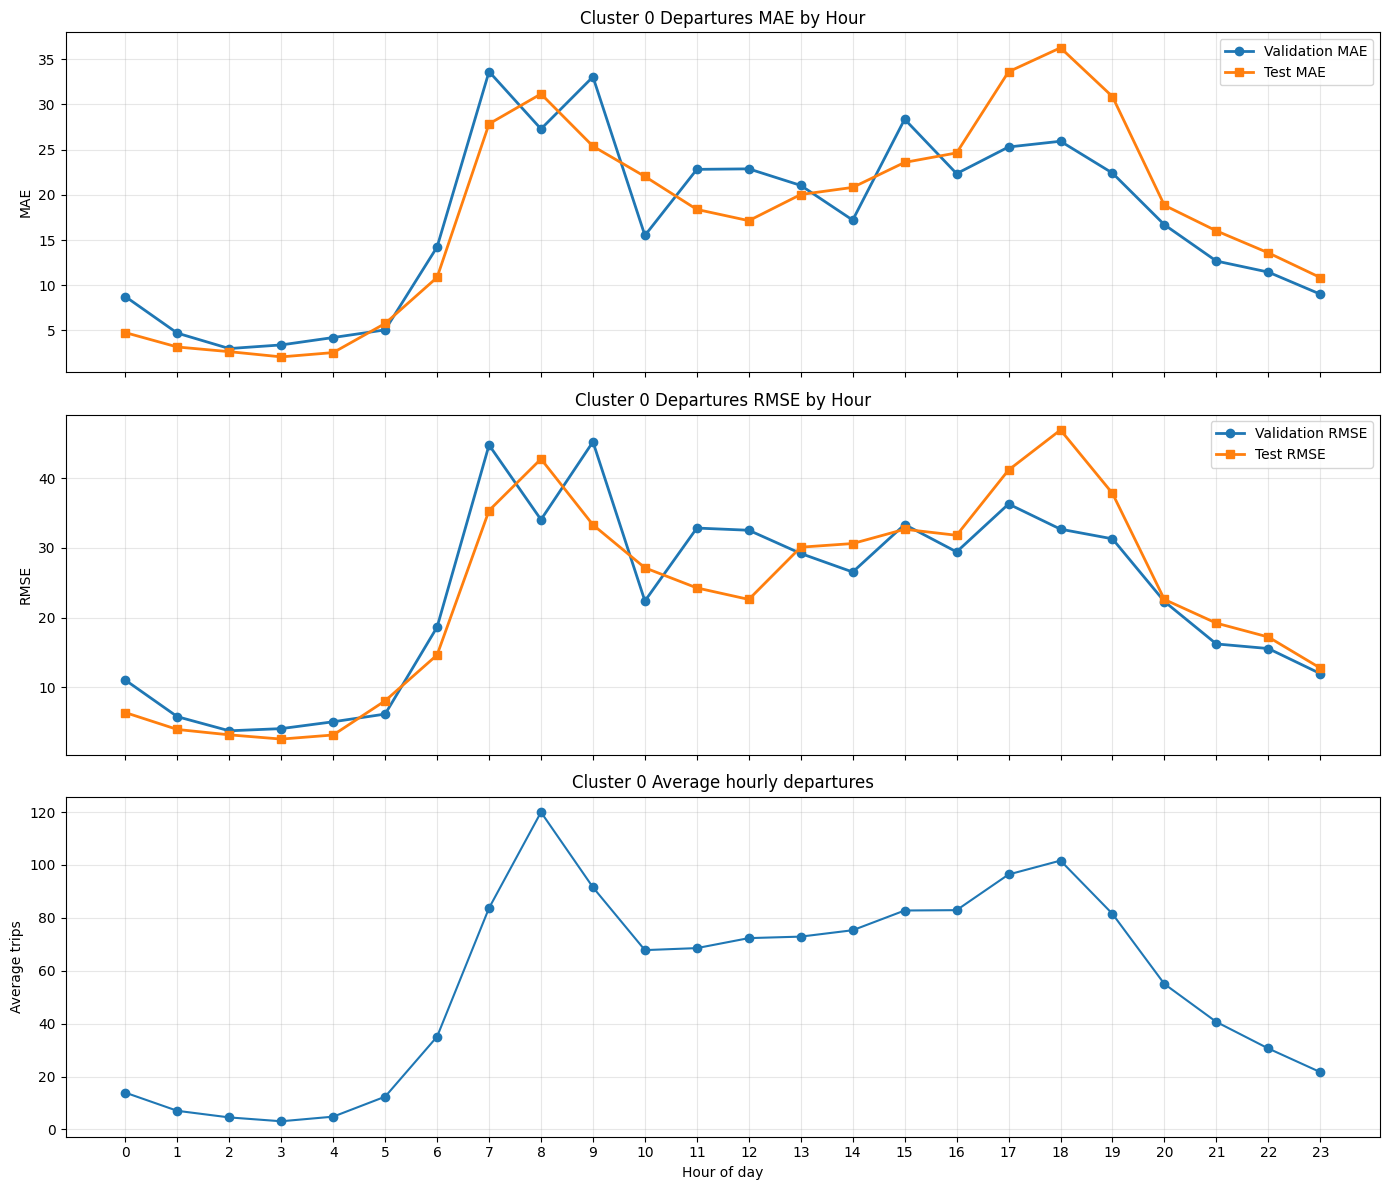


=== Cluster 0 Departures Summary Statistics ===
Average Validation MAE: 17.12
Average Test MAE: 17.62
Mid-day (11-15) Validation/Test MAE: 22.46 / 19.99
Peak (7-9,17-18) Validation/Test MAE: 29.04 / 30.86


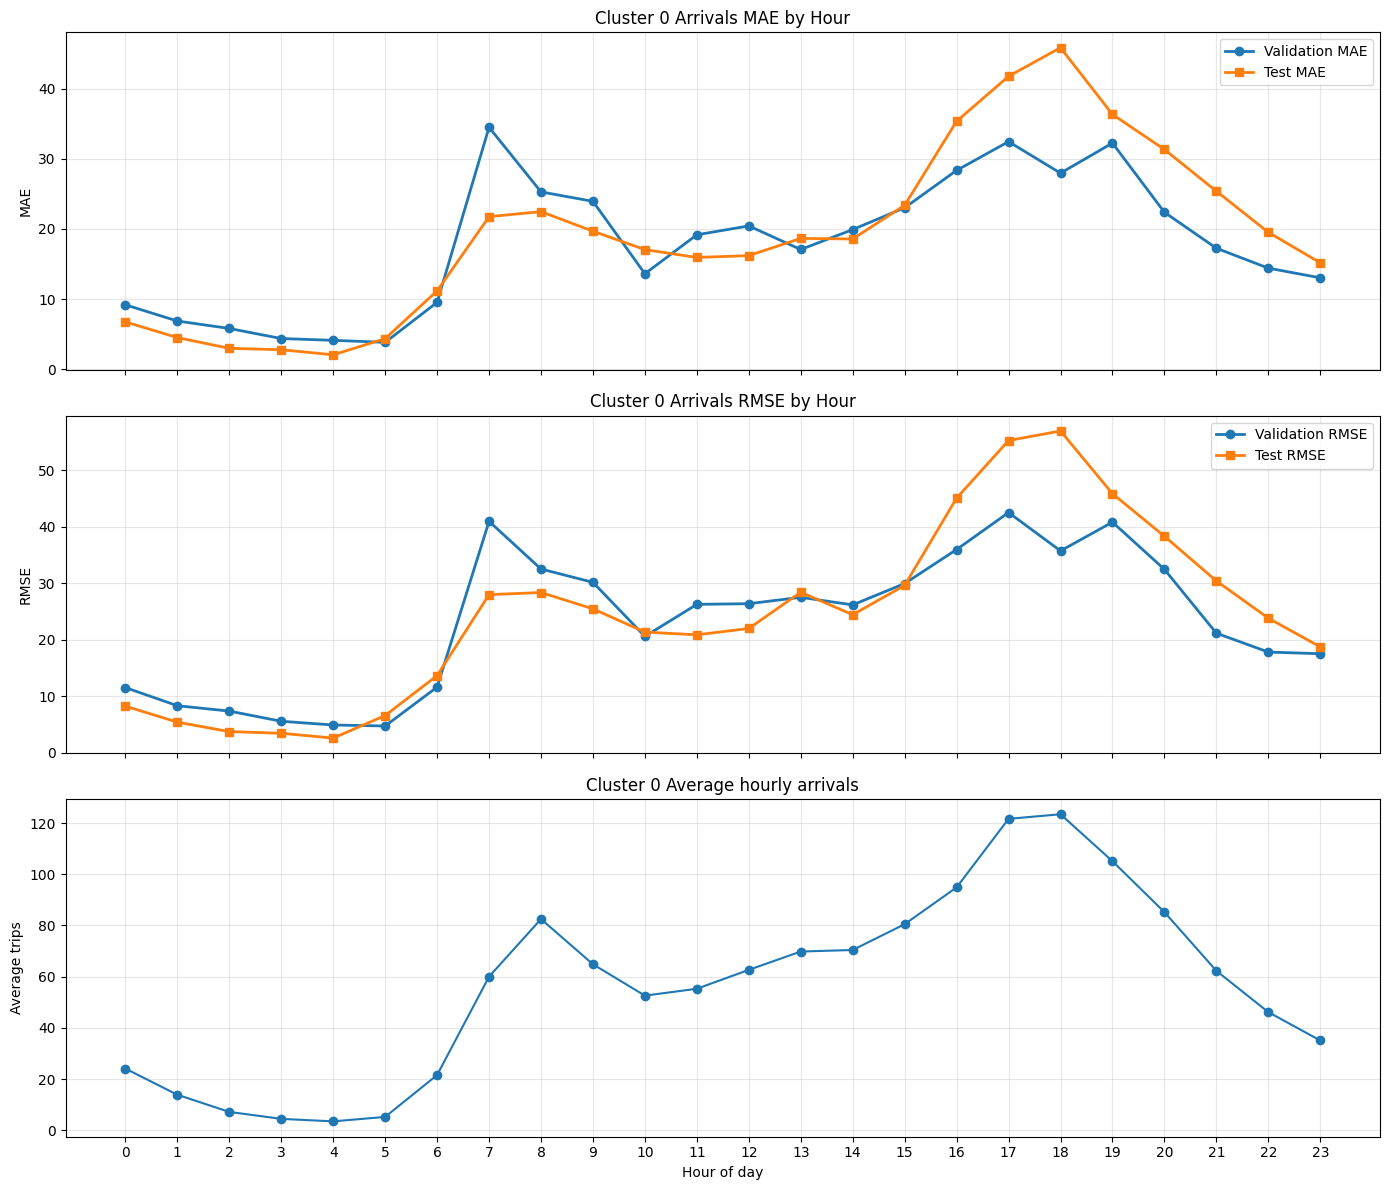


=== Cluster 0 Arrivals Summary Statistics ===
Average Validation MAE: 17.87
Average Test MAE: 19.13
Mid-day (11-15) Validation/Test MAE: 19.92 / 18.55
Peak (7-9,17-18) Validation/Test MAE: 28.82 / 30.29

##### Cluster 5 #####

=== Training models for Cluster 5 departures ===
Departures hour 00 | Val MAE   3.72 | Test MAE   3.06
Departures hour 01 | Val MAE   2.62 | Test MAE   2.27
Departures hour 02 | Val MAE   2.21 | Test MAE   1.27
Departures hour 03 | Val MAE   1.29 | Test MAE   1.17
Departures hour 04 | Val MAE   1.17 | Test MAE   1.15
Departures hour 05 | Val MAE   4.10 | Test MAE   3.89
Departures hour 06 | Val MAE   9.58 | Test MAE   9.48
Departures hour 07 | Val MAE  22.91 | Test MAE  29.13
Departures hour 08 | Val MAE  28.46 | Test MAE  44.30
Departures hour 09 | Val MAE  25.48 | Test MAE  24.45
Departures hour 10 | Val MAE  18.02 | Test MAE  15.16
Departures hour 11 | Val MAE  30.06 | Test MAE  15.53
Departures hour 12 | Val MAE  29.64 | Test MAE  22.77
Departures hour 13 | 

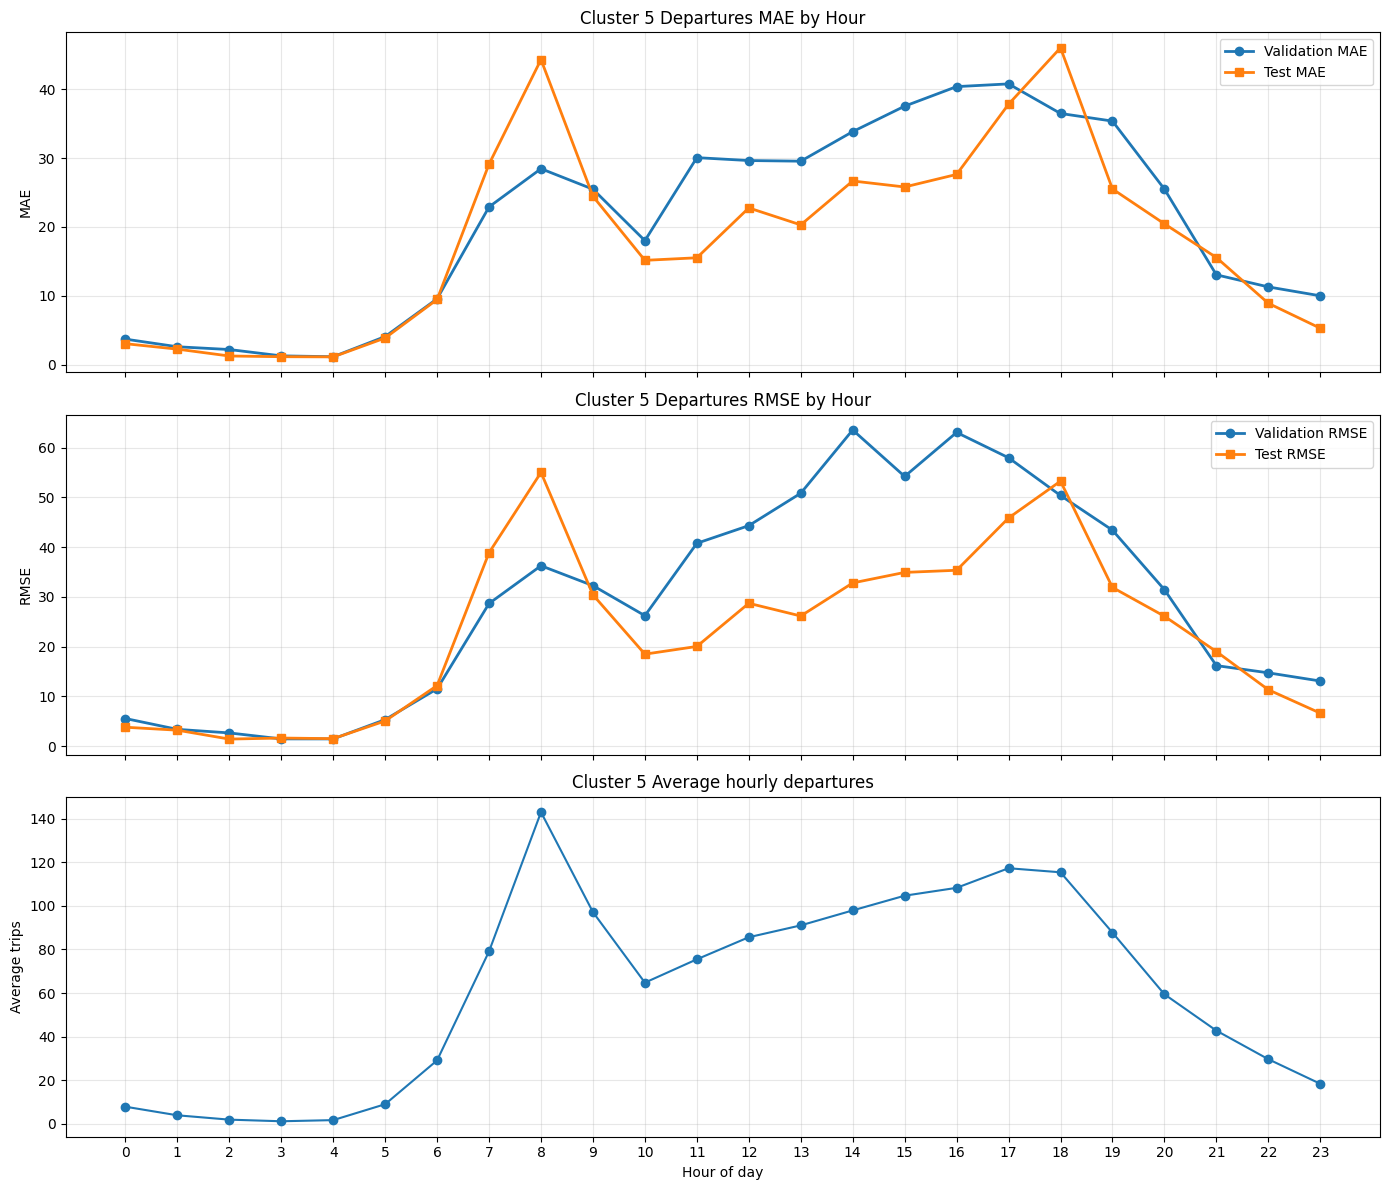


=== Cluster 5 Departures Summary Statistics ===
Average Validation MAE: 20.54
Average Test MAE: 18.07
Mid-day (11-15) Validation/Test MAE: 32.13 / 22.22
Peak (7-9,17-18) Validation/Test MAE: 30.82 / 36.34


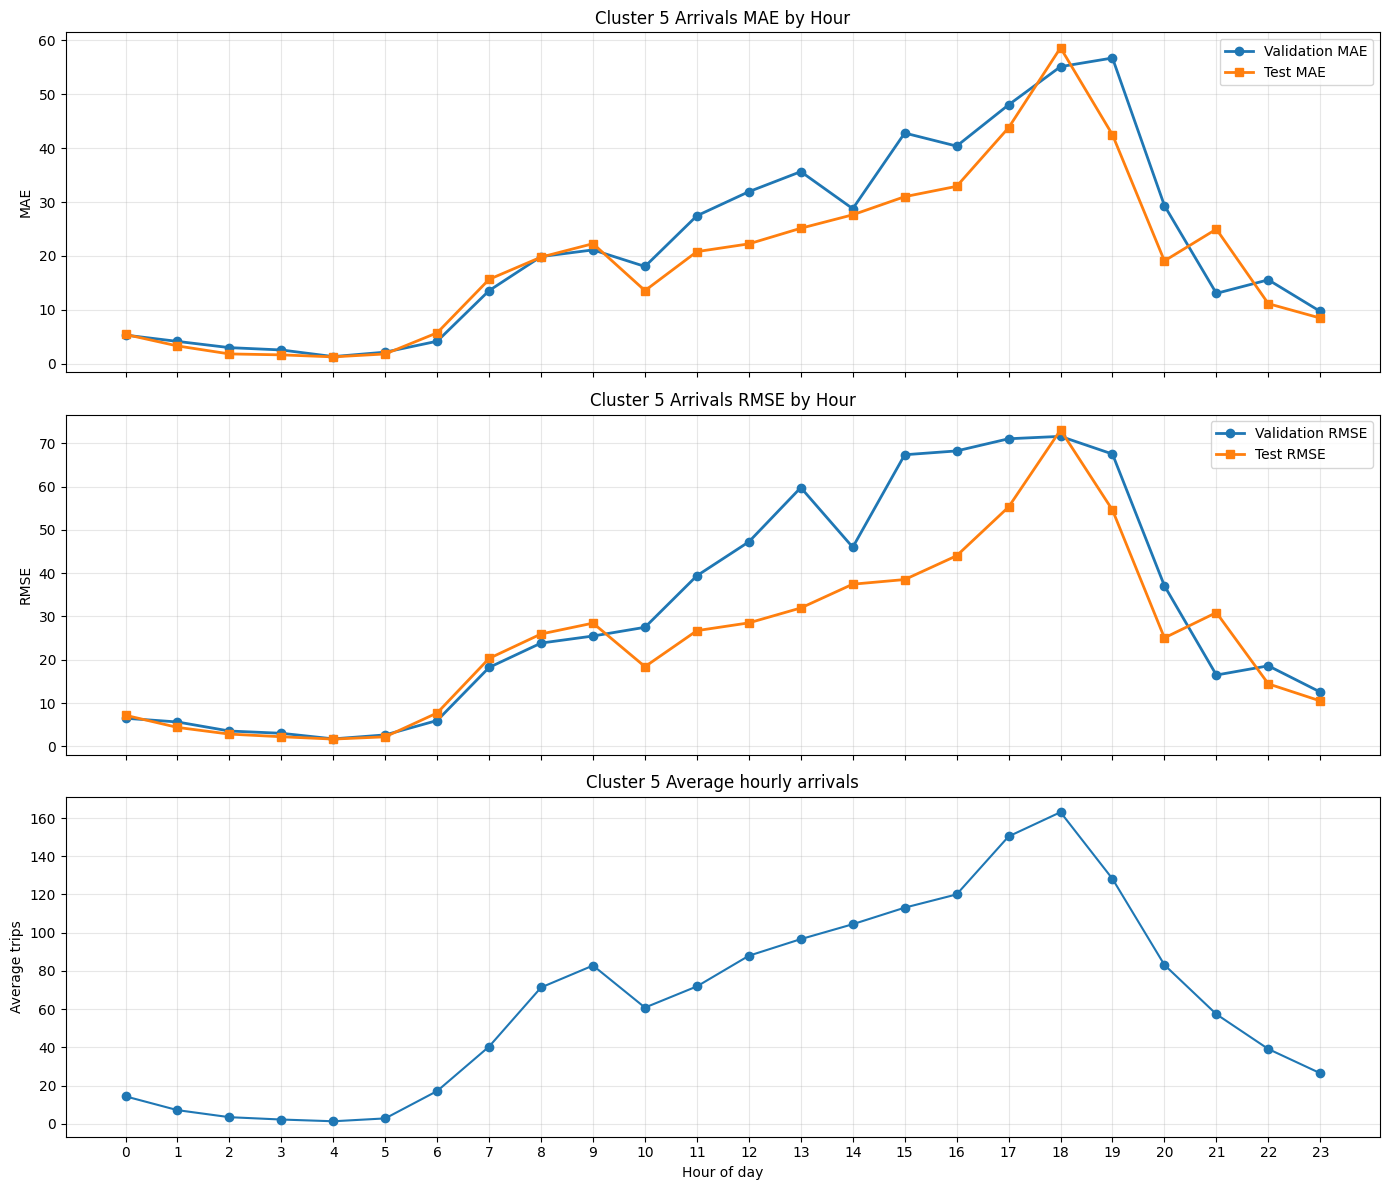


=== Cluster 5 Arrivals Summary Statistics ===
Average Validation MAE: 22.07
Average Test MAE: 19.19
Mid-day (11-15) Validation/Test MAE: 33.31 / 25.36
Peak (7-9,17-18) Validation/Test MAE: 31.54 / 32.02

##### Cluster 13 #####

=== Training models for Cluster 13 departures ===
Departures hour 00 | Val MAE  18.68 | Test MAE  10.75
Departures hour 01 | Val MAE  14.07 | Test MAE  11.07
Departures hour 02 | Val MAE   7.26 | Test MAE   7.37
Departures hour 03 | Val MAE   7.01 | Test MAE   5.70
Departures hour 04 | Val MAE   4.61 | Test MAE   3.80
Departures hour 05 | Val MAE   7.22 | Test MAE   6.49
Departures hour 06 | Val MAE  24.57 | Test MAE  22.62
Departures hour 07 | Val MAE  64.47 | Test MAE  52.41
Departures hour 08 | Val MAE  91.10 | Test MAE  82.43
Departures hour 09 | Val MAE  60.09 | Test MAE  66.29
Departures hour 10 | Val MAE  50.17 | Test MAE  49.95
Departures hour 11 | Val MAE  59.17 | Test MAE  55.44
Departures hour 12 | Val MAE  54.04 | Test MAE  55.59
Departures hour 13 

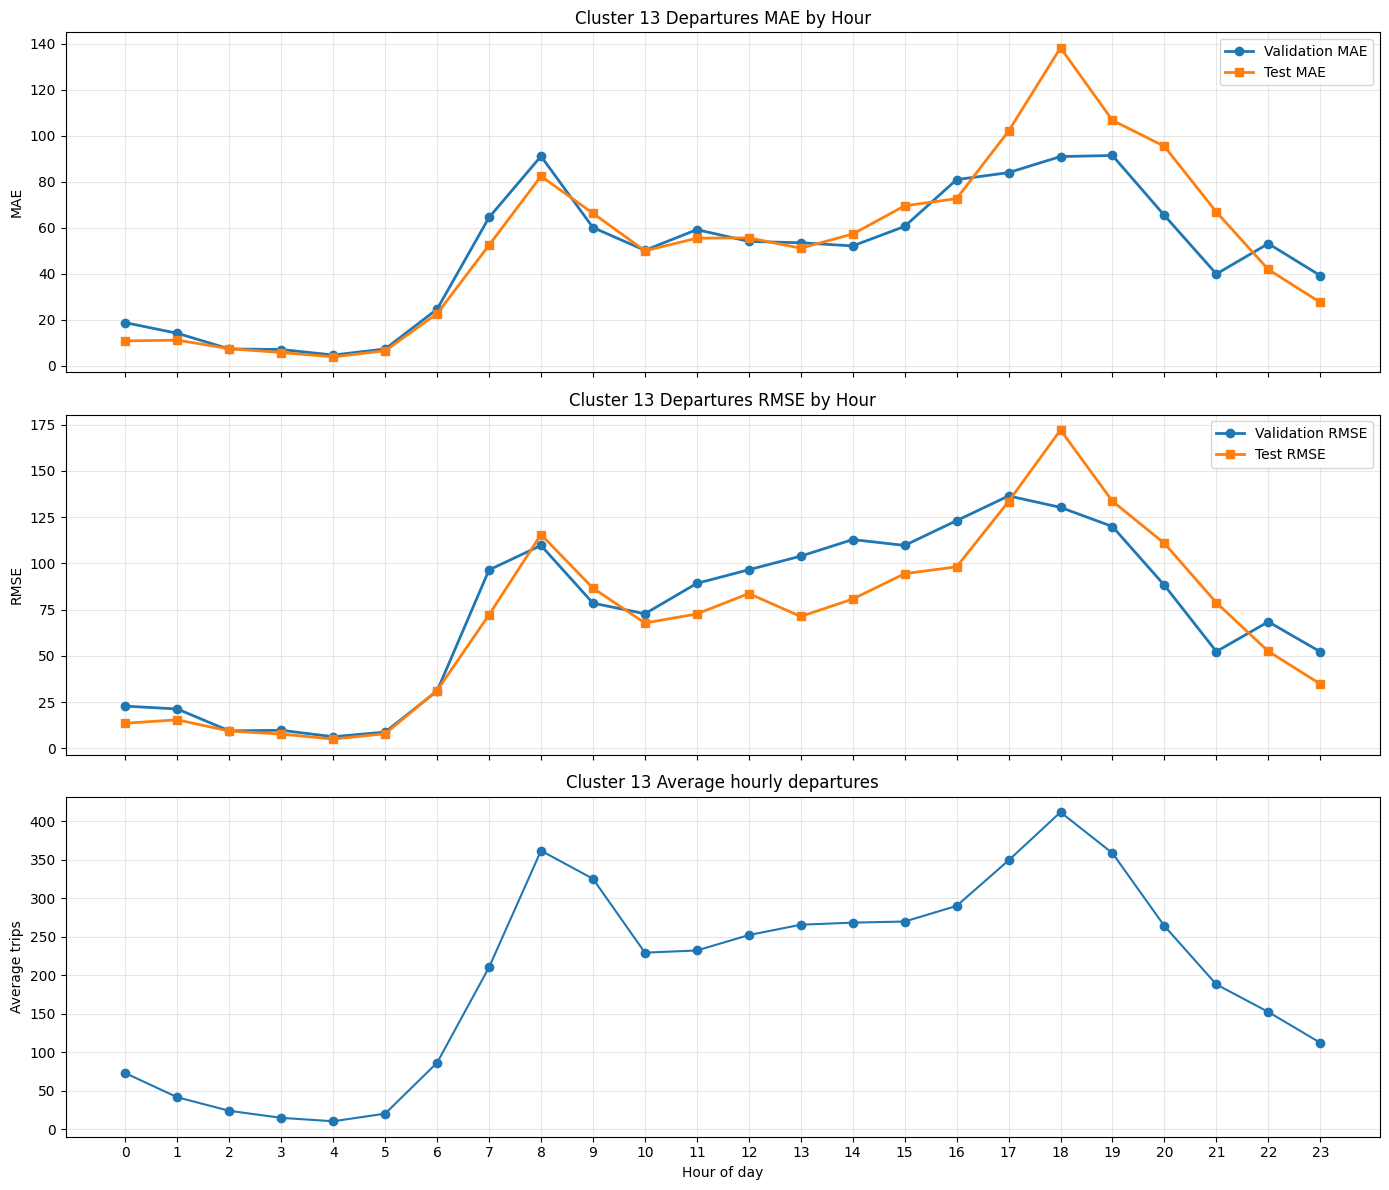


=== Cluster 13 Departures Summary Statistics ===
Average Validation MAE: 48.89
Average Test MAE: 52.46
Mid-day (11-15) Validation/Test MAE: 55.87 / 57.78
Peak (7-9,17-18) Validation/Test MAE: 78.12 / 88.29


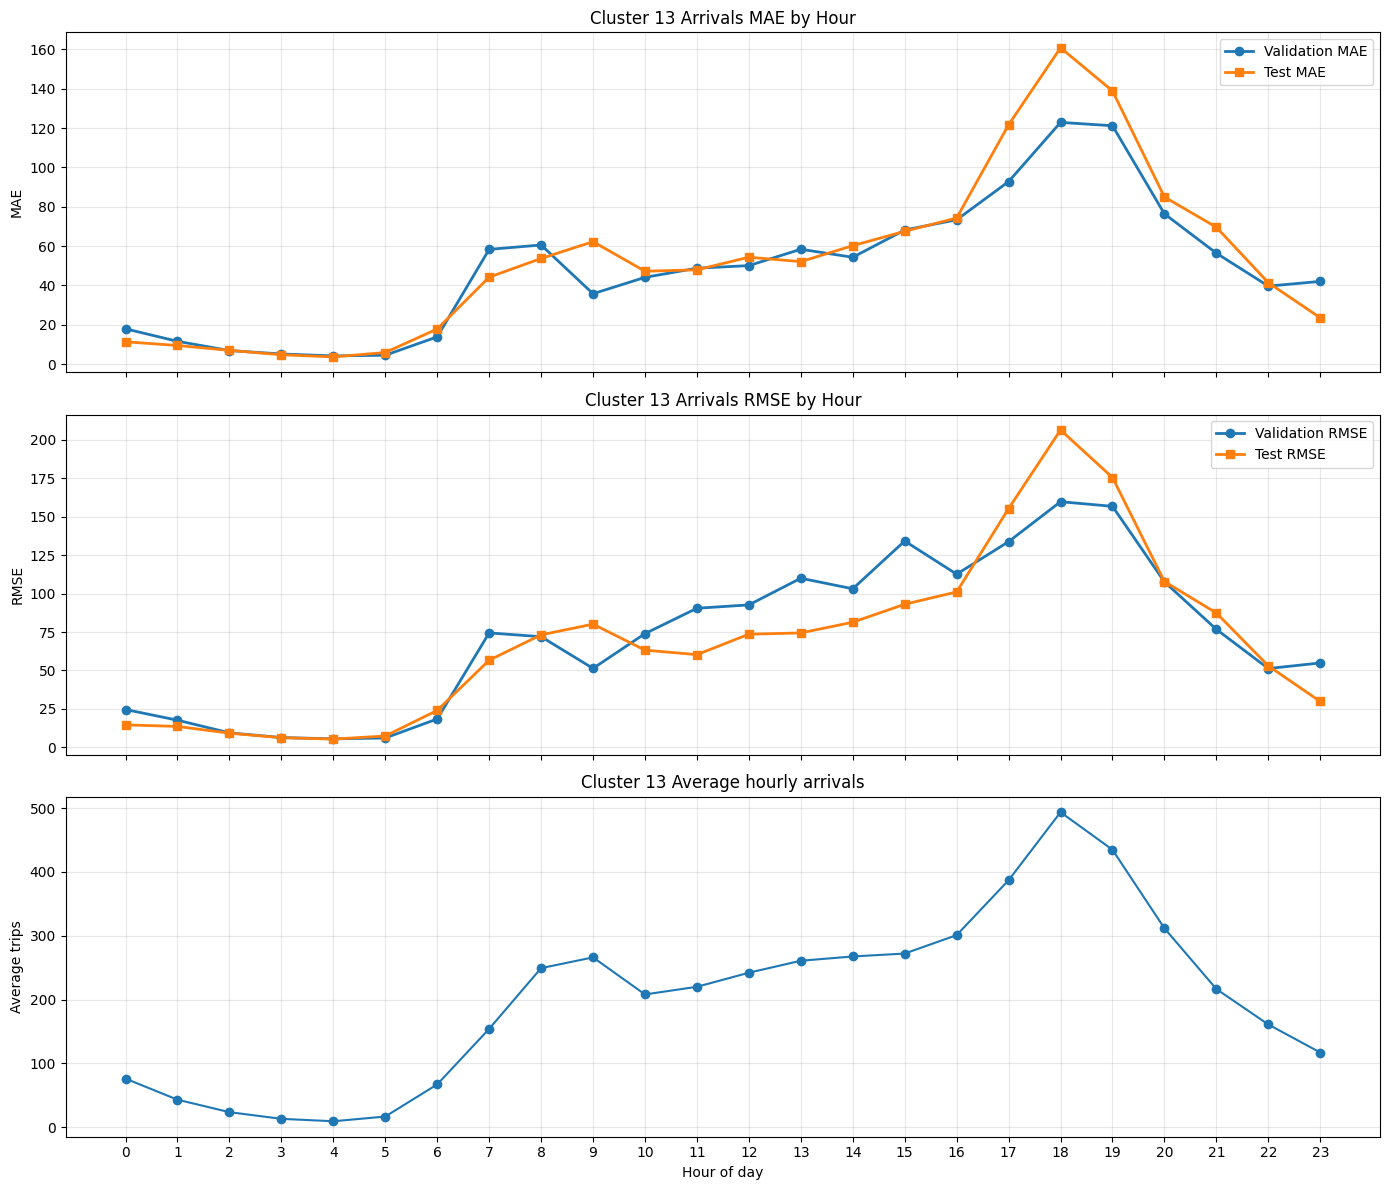


=== Cluster 13 Arrivals Summary Statistics ===
Average Validation MAE: 48.67
Average Test MAE: 52.73
Mid-day (11-15) Validation/Test MAE: 55.98 / 56.46
Peak (7-9,17-18) Validation/Test MAE: 74.11 / 88.57

##### Cluster 19 #####

=== Training models for Cluster 19 departures ===
Departures hour 00 | Val MAE   5.23 | Test MAE   3.49
Departures hour 01 | Val MAE   3.48 | Test MAE   3.22
Departures hour 02 | Val MAE   3.74 | Test MAE   2.14
Departures hour 03 | Val MAE   1.73 | Test MAE   1.38
Departures hour 04 | Val MAE   1.61 | Test MAE   1.32
Departures hour 05 | Val MAE   5.60 | Test MAE   3.73
Departures hour 06 | Val MAE   5.99 | Test MAE   5.51
Departures hour 07 | Val MAE  12.85 | Test MAE  10.28
Departures hour 08 | Val MAE  23.95 | Test MAE  18.09
Departures hour 09 | Val MAE  18.85 | Test MAE  18.96
Departures hour 10 | Val MAE  13.49 | Test MAE  12.69
Departures hour 11 | Val MAE  14.48 | Test MAE  13.90
Departures hour 12 | Val MAE  19.05 | Test MAE  14.87
Departures hour 13

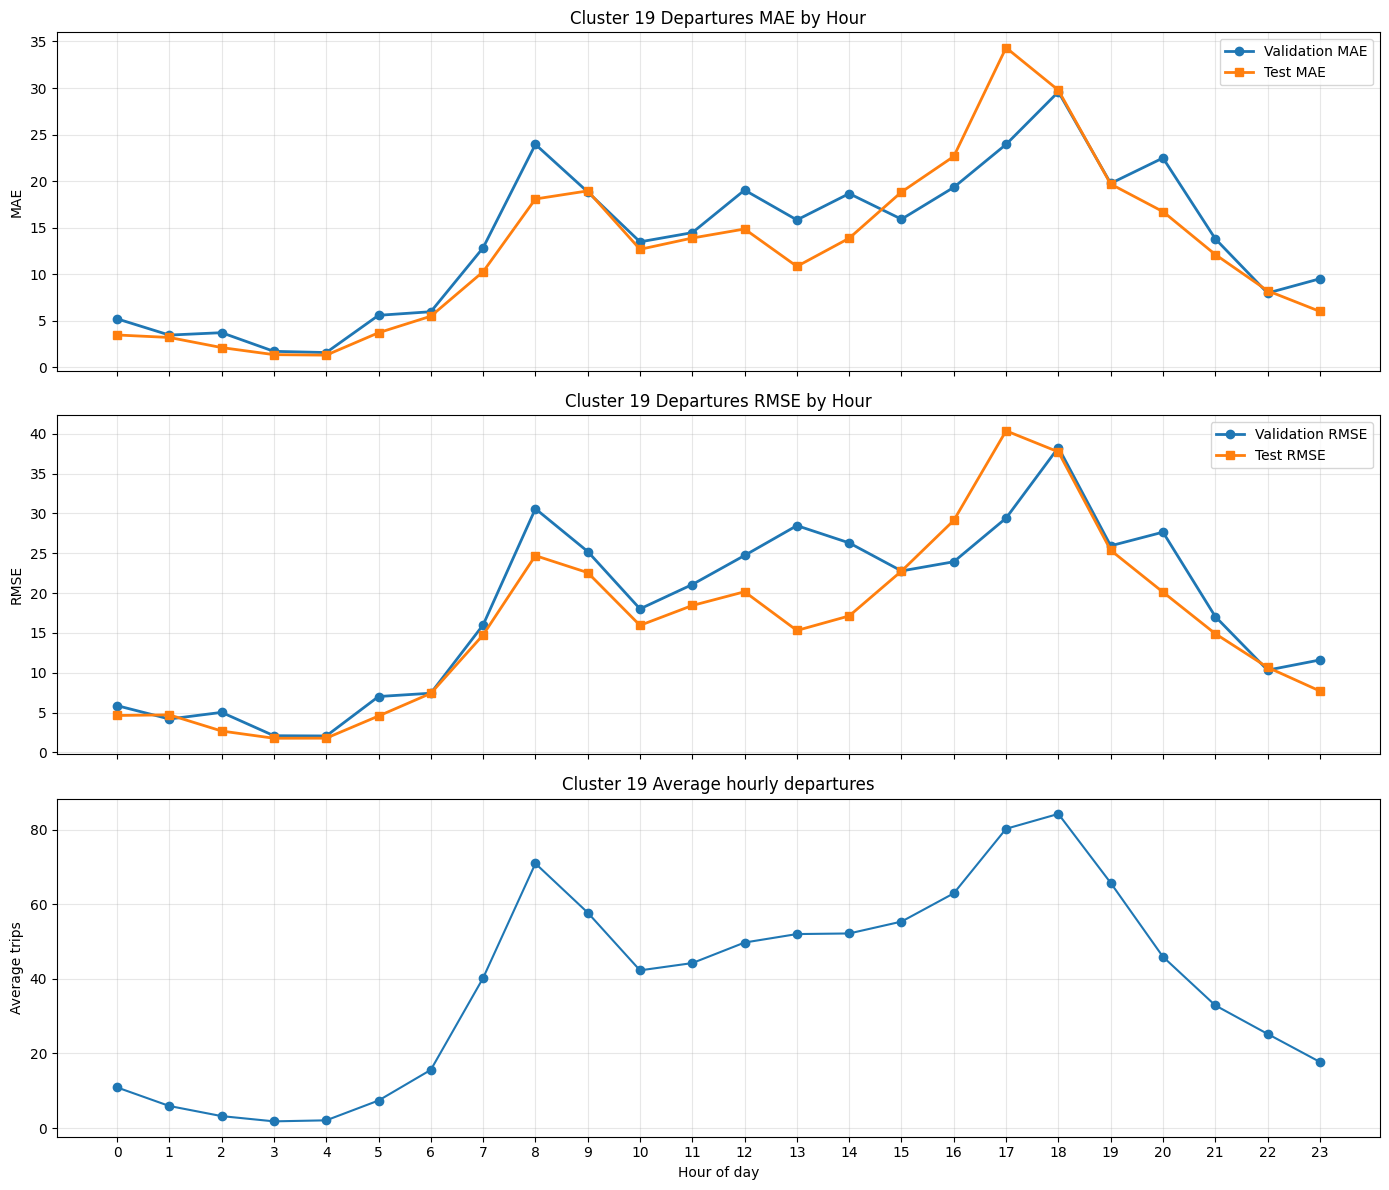


=== Cluster 19 Departures Summary Statistics ===
Average Validation MAE: 13.62
Average Test MAE: 12.61
Mid-day (11-15) Validation/Test MAE: 16.79 / 14.47
Peak (7-9,17-18) Validation/Test MAE: 21.84 / 22.29


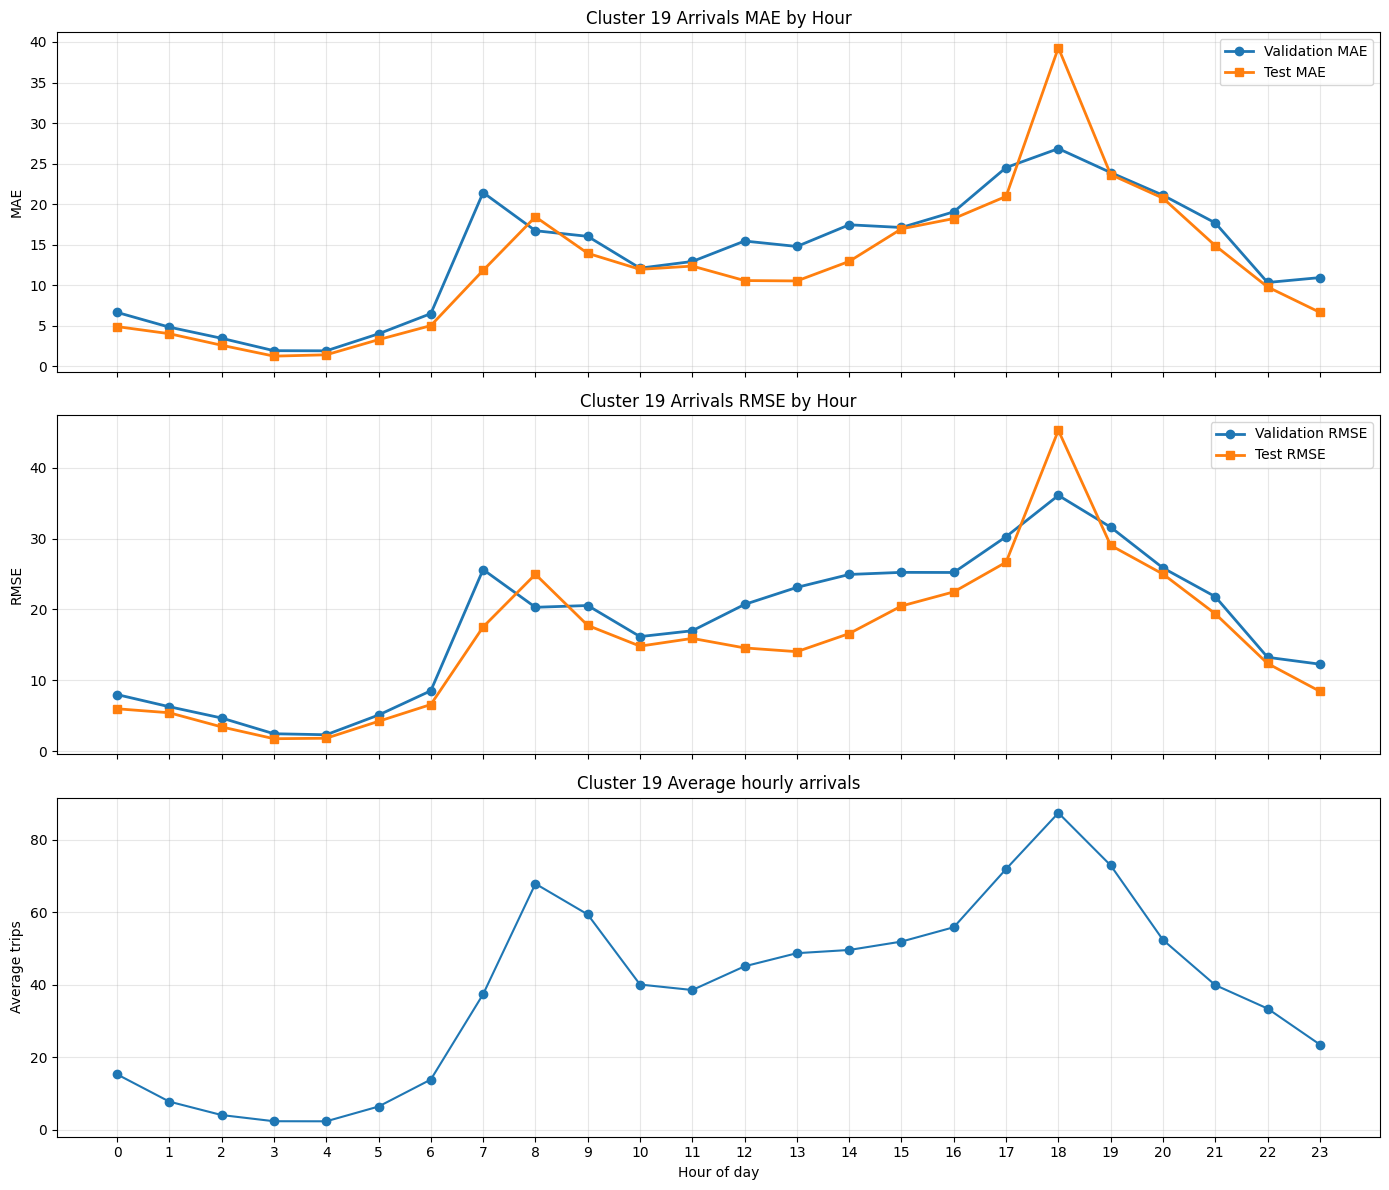


=== Cluster 19 Arrivals Summary Statistics ===
Average Validation MAE: 13.67
Average Test MAE: 12.36
Mid-day (11-15) Validation/Test MAE: 15.56 / 12.69
Peak (7-9,17-18) Validation/Test MAE: 21.12 / 20.90


In [17]:
target_clusters = [0, 5, 13, 19]
cluster_results: Dict[int, Dict[str, Any]] = {}

for idx, cluster_id in enumerate(target_clusters):
    label = f"Cluster {cluster_id}"
    print(f"\n##### {label} #####")
    cluster_results[cluster_id] = run_cluster_pipeline(
        cluster_hourly,
        cluster_id,
        cluster_label=label,
        display_samples=(idx == 0),
        display_plots=True,
    )


In [19]:
# Combined summary tables by cluster and target
combined_summary = (
    pd.concat(
        {
            cluster_id: pd.concat(
                result['summary_tables'],
                names=['target', 'hour'],
            )
            for cluster_id, result in cluster_results.items()
            if result.get('summary_tables')
        },
        names=['cluster', 'target', 'hour'],
    )
    if cluster_results
    else pd.DataFrame()
)
combined_summary.head(24)


Val_MAE   Val_RMSE   Test_MAE  Test_RMSE
cluster target     hour                                            
0       departures 0      8.739144  11.052105   4.753179   6.403072
                   1      4.696798   5.816256   3.164348   3.984970
                   2      2.991400   3.793897   2.647298   3.214388
                   3      3.393320   4.106814   2.070723   2.608613
                   4      4.211487   5.088242   2.545881   3.195146
                   5      5.056988   6.191120   5.767950   8.093241
                   6     14.230312  18.654682  10.864055  14.664270
                   7     33.636438  44.744968  27.851627  35.359670
                   8     27.288980  34.052695  31.163080  42.746545
                   9     33.055982  45.203611  25.375064  33.309240
                   10    15.504857  22.393686  22.030781  27.148362
                   11    22.818292  32.846077  18.384038  24.269665
                   12    22.873333  32.531811  17.140819  22.620691
                   13    21.041010  29.201592  20.034574  30.105353
                   14    17.201742  26.545514  20.821384  30.626736
                   15    28.364665  33.352043  23.588057  32.670581
                   16    22.344414  29.429391  24.638284  31.810346
                   17    25.293219  36.291729  33.617816  41.164381
                   18    25.927609  32.685761  36.268260  46.899583
                   19    22.406407  31.302592  30.869715  37.818764
                   20    16.689879  22.319053  18.839972  22.610247
                   21    12.673679  16.240571  16.015743  19.222054
                   22    11.451113  15.580648  13.583065  17.232816
                   23     9.011349  11.993251  10.852124  12.786255

### Cluster Comparison Overview

Execute the pipeline cell above to materialize `cluster_results` for clusters 0, 5, 13, and 19. The summary dataframe and metric overview below provide quick checks that each cluster produced validation and test metrics with reasonable magnitudes.

In [20]:
# Compute average MAE metrics by cluster and target
cluster_metric_overview = (
    combined_summary.groupby(['cluster', 'target'])[['Val_MAE', 'Test_MAE']].mean()
    if not combined_summary.empty
    else pd.DataFrame()
)

print("=== Average Val_MAE & Test_MAE by cluster and target ===")
print("\n"*2)
print(cluster_metric_overview)





=== Average Val_MAE & Test_MAE by cluster and target ===



                      Val_MAE   Test_MAE
cluster target                          
0       arrivals    17.868661  19.127774
        departures  17.120934  17.620327
5       arrivals    22.074260  19.193306
        departures  20.543391  18.068491
13      arrivals    48.673637  52.728753
        departures  48.892539  52.463159
19      arrivals    13.666885  12.356436
        departures  13.622384  12.613614
